# Tutorial 8: Visualize results

In [1]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_img import *
from datasets.data_manager_human_lymph_node import Lymph_node

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


from palettable.cartocolors.diverging import *
from palettable.scientific.diverging import *

### Load dataset

In [2]:
rna_path = '/home/wzk/ST_data/2024_nmethods_SpatialGlue_Human_lymph_node_3slides/slice2/s2_adata_rna.h5ad'
protein_path = '/home/wzk/ST_data/2024_nmethods_SpatialGlue_Human_lymph_node_3slides/slice2/s2_adata_adt.h5ad'

adata_rna_testing = sc.read_h5ad(rna_path)
adata_protein_testing = sc.read_h5ad(protein_path)

### Load args

In [3]:
%run ./args/args_human_lymph_node.py
args = args

### Create dataloader

In [4]:
# create the dataloaders
dataset = Lymph_node(adata_path=args.adata_path, n_top_genes=args.n_source)
trainloader, testloader = human_node_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 13638 edges, 3484 cells.
3.9145 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 27174 edges, 3484 cells.
7.7997 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 13138 edges, 3359 cells.
3.9113 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 26192 edges, 3359 cells.
7.7976 neighbors per cell on average.
=> Human lymph node loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  After filting  3484 spots
  test     |  After filting  3359 spots
  ------------------------------


### Model initialization

In [5]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.protein_length
model = NicheTrans(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('NicheTrans_human_lymph_node_last.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans(
    (encoder): NetBlock(
      (noise_dropout): Dropout(p=0.5, inplace=False)
      (linear_list): ModuleList(
        (0): Linear(in_features=909, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (bn_list): ModuleList(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_list): ModuleList(
        (0-1): 2 x LeakyReLU(negative_slope=0.01)
      )
      (dropout_list): ModuleList(
        (0): Dropout(p=0.1, inplace=False)
      )
    )
    (fusion_omic): Self_Attention(
      (to_q): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=False)
      )
      (to_k): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=False)
      )
      (to_v): Linear(in_features=256, out_features=256, bias=Fa

### Model inference 

In [6]:
pd_value, gt_value = [], [] 

with torch.no_grad():
    for _, (rna, protein, rna_neighbors, _) in enumerate(testloader):

        rna, protein, rna_neighbors = rna.cuda(), protein.cuda(), rna_neighbors.cuda()
        source, target, source_neightbors = rna, protein, rna_neighbors

        outputs = model(source, source_neightbors)

        pd_value.append(outputs)
        gt_value.append(target)

pd_value = torch.cat(pd_value, dim=0).cpu().numpy()
gt_value = torch.cat(gt_value, dim=0).cpu().numpy()

### Model evaluation

In [ ]:
from utils.evaluation import evaluator
pearson_sample_list, spearman_sample_list, _ = evaluator(pd_value, gt_value)

print(pearson_sample_list.mean())
print(spearman_sample_list.mean())

0.4077716176103157
0.45140868097423353


In [8]:
pd_value = np.exp((pd_value * dataset.std) + dataset.mean)
gt_value = np.exp((gt_value * dataset.std) + dataset.mean)

In [9]:
proteins = adata_protein_testing.var['gene_ids'].values

for index, protein in enumerate(proteins):
    adata_protein_testing.obs['pd_' + protein ] = pd_value[:, index]
    adata_protein_testing.obs['gt_' + protein ] = gt_value[:, index]
    

<Axes: title={'center': 'Prediction HLA-DRA'}, xlabel='spatial1', ylabel='spatial2'>

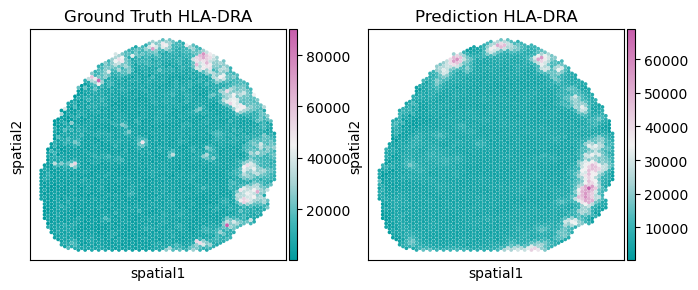

In [10]:
protein = 'HLA-DRA'

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.embedding(adata_protein_testing, basis='spatial', color='gt_' + protein, title=f'Ground Truth {protein}', ax=axs[0], show=False, cmap=Tropic_7.mpl_colormap, size=30, vmax=90000) 
sc.pl.embedding(adata_protein_testing, basis='spatial', color='pd_' + protein, title=f'Prediction {protein}', ax=axs[1], show=False, cmap=Tropic_7.mpl_colormap, size=30) 

<Axes: title={'center': 'Prediction PAX5'}, xlabel='spatial1', ylabel='spatial2'>

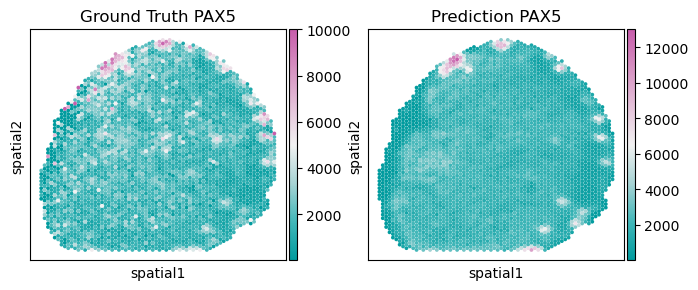

In [11]:
protein = 'PAX5'

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.embedding(adata_protein_testing, basis='spatial', color='gt_' + protein, title=f'Ground Truth {protein}', ax=axs[0], show=False, cmap=Tropic_7.mpl_colormap, size=30) 
sc.pl.embedding(adata_protein_testing, basis='spatial', color='pd_' + protein, title=f'Prediction {protein}', ax=axs[1], show=False, cmap=Tropic_7.mpl_colormap, size=30) 